## CH11 训练深度神经网络

In [108]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
#import sklearn
#assert sklearn.__version__ >= "0.20"

try:
    # %tensorflow_version only exists in Colab.
    %tensorflow_version 2.x
except Exception:
    pass

# TensorFlow ≥2.0 is required
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.0"

%load_ext tensorboard

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "deep"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


**·CH10未解决的问题：**

------------

①梯度消失问题或梯度爆炸问题

②对于如此大的网络，你可能没有足够的训练数据，或者做标签的成本太高

③训练可能会非常缓慢

④过拟合风险：具有数百万个参数的模型会有严重过拟合训练集的风险，尤其是在没有足够的训练实例或噪声太大的情况下


**·本章结构：**

------------

①梯度消失和梯度爆炸的含义及解决措施

②迁移学习和无监督预训练（解决标签数据很少的问题）

③极大加速训练大型模型的各种优化器

④针对大型神经网络的正则化技术



### 梯度消失与梯度爆炸问题

    ☺首先，搞清楚问题怎么来的。



**Q：首先，为什么要考虑梯度？**

A：反向传播算法的工作原理是从输出层到输入层，并在此过程中传播误差梯度。一旦算法计算出成本函数相对于网络中每个参数的梯度，就可以使用这些梯度以梯度下降步骤来更新每个参数。

**Q：什么是梯度消失和梯度爆炸？**


A：$\omega ← \omega + \Delta \omega$，给定学习率$\alpha,\Delta \omega = -\alpha \frac{\partial Loss}{\omega}$,如果更新第二层隐层的权值信息，根据链式求导法则，更新梯度信息为: $$\Delta\omega_{1}=\frac{\partial Loss}{\omega_{2}}=\frac{\partial Loss}{\partial f_{3}}·\frac{\partial f_{3}}{\partial f_{2}}·\frac{\partial f_{2}}{\omega_{2}}$$

上式中，$\frac{\partial f_{2}}{\omega_{2}}=f_{1}$，即第二隐藏层的输入。

$\frac{\partial f_{3}}{\partial f_{2}}$就是对激活函数进行求导，如果此部分大于1，那么层数增多的时候，最终的求出的梯度更新将以指数形式增加，即发生梯度爆炸，如果此部分小于1，那么随着层数增多，求出的梯度更新信息将会以指数形式衰减，即发生了梯度消失。


**举例子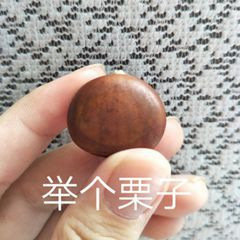**

Sigmoid函数（即Logistics函数）发生梯度消失：

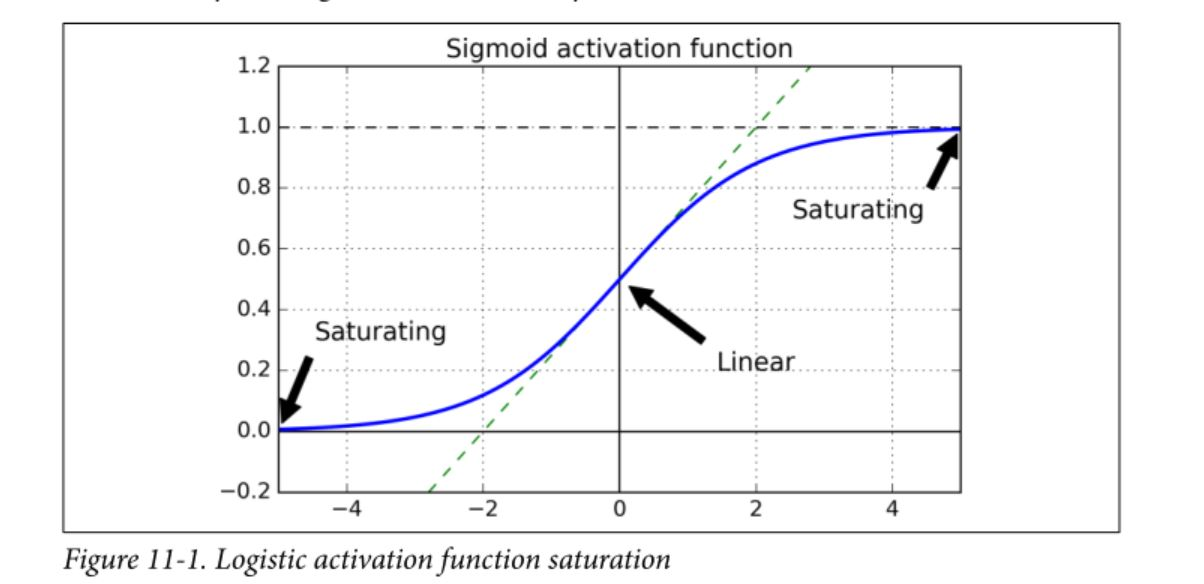

由上图，当输入变大（负数或正数）时，该函数会以0或1饱和，并且导数非常接近0。因此反向传播开始时它几乎没有梯度可以通过网络传播回去。当反向传播通过顶层向下传播时，存在的小梯度不断被稀释（eg.0.1^10），因此对于底层来说，实际上什么也没有留下。

PS 梯度爆炸：它出现在递归神经网络中（有兴趣自行了解）。

···

    ☺接下来，介绍几种解决问题的办法。


 #### Glorot和He初始化

    他们指出，我们需要信号在两个方向上正确流动：进行预测时，信号为正向；在反向传播梯度时，信号为反向。我们既不希望信号消失，也不希望它爆炸并饱和。为了使信号正确流动，作者认为，我们需要每层输出的方差等于其输入的方差。
Glorot和Bengio提出了一个很好的折中方案，在实践中证明很好地发挥作用：必须按照【公式】中所述的随机初始化每层的连接权重，其中$fan_{avg}=（fan_{in}+fan_{out}）/2$。这种初始化策略称为Xavier初始化或者Glorot初始化，以论文的第一作者命名。

【公式】Glorot初始化（使用逻辑激活函数时）`

Option1:正态分布，其均值为0，方差为$\sigma^2 = \frac{1}{fan_{avg}}$

Option2:$-r$和$+r$之间的均匀分布，其中,$r=\sqrt \frac{3}{fan_{avg}}$



初始化|激活函数|方差|
---|--- |---|
Glorot|None tanh logistic softmax|$\frac{1}{fan_{avg}}$|
He|RelU和变体|$\frac{2}{fan_{in}}$|
LeCun|SELU|$\frac{1}{fan_{in}}$|

默认情况下，Keras使用具有均匀分布的Glorot初始化。创建层时，可以通过设置kernel_initializer="he_uniform"或kernel_initializer="he_normal"来将其更改为He初始化：

In [109]:
keras.layers.Dense(10, activation="relu", kernel_initializer="he_normal") 

如果你要使用均匀分布但基于$fan_{avg}$而不是$fan_{in}$进行He初始化，则可以使用Variance Scaling初始化，如下所示：

In [110]:
he_avg_init = keras.initializers.VarianceScaling(scale=2., mode='fan_avg', distribution='uniform') 
keras.layers.Dense(10, activation="sigmoid", kernel_initializer=he_avg_init) 

#### 非饱和激活函数

    why Sigmoid？ ——>仿生 ——>but梯度消失——>Relu
    why Relu？    ——>正值不饱和 ——>but“濒死的ReLU”的问题 ——> Relu变体
    ☺本节将介绍3种Relu变体——leaky ReLU（PReLU），Exponential Linear Unit，（ELU），Scaled ELU，SEIU

**Q：濒死的ReLU”的问题？**

A：在训练过程中，某些神经元实际上“死亡”了，这意味着它们停止输出除0以外的任何值。在某些情况下，你可能会发现网络中一半的神经元都死了，特别是如果你使用较大的学习率。当神经元的权重进行调整时，其输入的加权和对于训练集中的所有实例均为负数，神经元会死亡。发生这种情况时，它只会继续输出零，梯度下降不会再影响它，因为ReLU函数的输入为负时其梯度为零。

*变体一：*

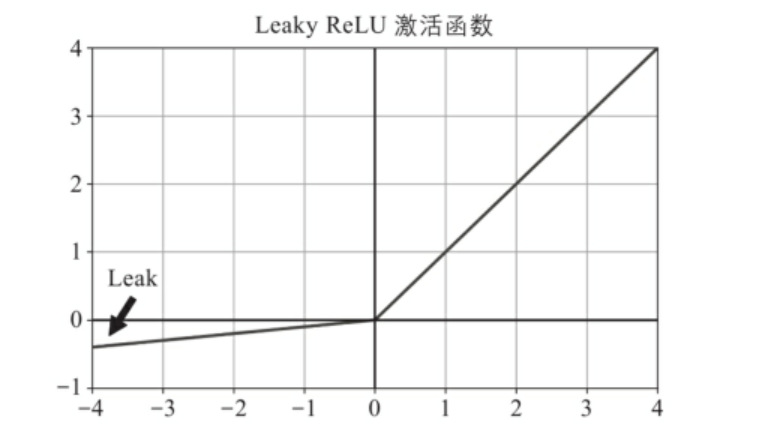


①它是z<0时函数的斜率，通常设置为0.01。这个小的斜率确保了leaky ReLU永远不会死亡。

②据报道，PReLU在大型图像数据集上的性能明显优于ReLU，但是在较小的数据集上，它存在过拟合训练集的风险。

*变体二：*

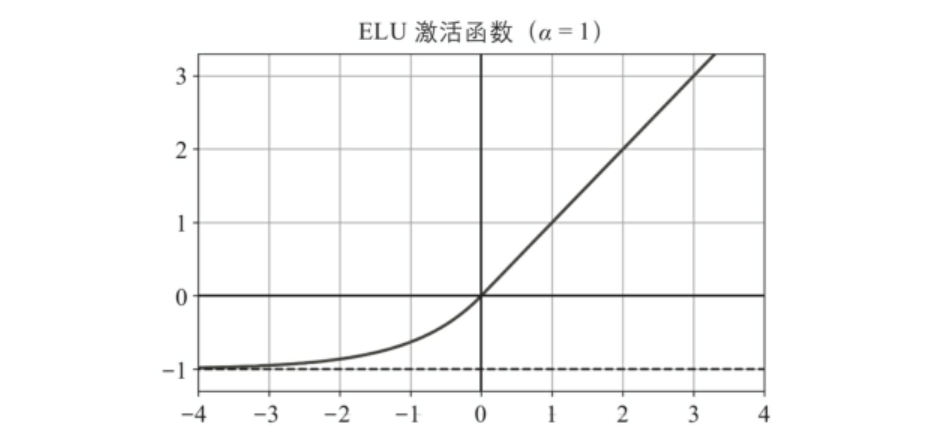

$$ \begin{equation}
ELU_{\alpha}(z)=\left\{
\begin{aligned}
\alpha(exp(z)-1) & &if Z<0, \\
Z  &   &if Z>=0.
\end{aligned}
\right.
\end{equation}
$$

①当z<0时，它取负值，这使该单元的平均输出接近于0，有助于缓解梯度消失的问题。

②如果α等于1，则该函数在所有位置（包括z=0左右）都是平滑的，这有助于加速梯度下降，因为它在z=0的左右两侧弹跳不大。

③ELU激活函数的主要缺点是它的计算比ReLU函数及其变体要慢（由于使用了指数函数）。它在训练过程中更快的收敛速度弥补了这种缓慢
的计算，但是在测试时，ELU网络将比ReLU网络慢。

*变体三：*

可扩展的ELU（Scaled ELU，SEIU）激活函数

①如果你构建一个仅由密集层堆叠组成的神经网络，并且如果所有隐藏层都使用SELU激活函数，则该网络是自归一化的：每层的输出倾向于在训练过程中保留平均值0和标准差1，从而解决了梯度消失/梯度爆炸的问题。

②自归一化的条件：

a.输入特征必须是标准化的（平均值为0，标准差为1）

b.每个隐藏层的权重必须使用LeCun正态初始化。在Keras中，这意味着设置kernel_initializer="lecun_normal"

    ☺那么，你应该对深度神经网络的隐藏层使用哪个激活函数呢？

通常：SELU>ELU>leaky ReLU（及其变体）>ReLU>tanh>logistic

①如果网络的架构不能自归一化，那么ELU的性能可能会优于SELU（因为SELU在z=0时不平滑）

②如果你非常关心运行时延迟，那么你可能更喜欢leaky ReLU。

③如果你不想调整其他超参数，则可以使用Keras使用的默认α值（例如，leaky ReLU为0.3）。

④如果你有空闲时间和计算能力，则可以使用交叉验证来评估其他激活函数，例如，如果网络过拟合，则为RReLU；如果你的训练集很大，则为PReLU。

最后，由于ReLU是迄今为止最常用的激活函数，因此许多库和硬件加速器都提供了ReLU特定的优化。因此，如果你将速度放在首位，那么ReLU可能仍然是最佳选择。

要使用leaky ReLU激活函数，创建一个LeakyReLU层，并将其添加到你想要应用它的层之后的模型中

In [111]:
#导入数据集：shion MNIST
(X_train_full, y_train_full), (X_test, y_test) = keras.datasets.fashion_mnist.load_data()
X_train_full = X_train_full / 255.0
X_test = X_test / 255.0
X_valid, X_train = X_train_full[:5000], X_train_full[5000:]
y_valid, y_train = y_train_full[:5000], y_train_full[5000:]

In [112]:
tf.random.set_seed(42)
np.random.seed(42)

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, kernel_initializer="he_normal"),
    keras.layers.LeakyReLU(),
    keras.layers.Dense(100, kernel_initializer="he_normal"),
    keras.layers.LeakyReLU(),
    keras.layers.Dense(10, activation="softmax")
])

In [113]:
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=keras.optimizers.SGD(lr=1e-3),
              metrics=["accuracy"])

In [114]:
history = model.fit(X_train, y_train, epochs=10,
                    validation_data=(X_valid, y_valid))

Train on 55000 samples, validate on 5000 samples
Epoch 1/10
55000/55000 [==============================] - 4s 71us/sample - loss: 1.2806 - accuracy: 0.6250 - val_loss: 0.8882 - val_accuracy: 0.7150
Epoch 2/10
55000/55000 [==============================] - 4s 64us/sample - loss: 0.7954 - accuracy: 0.7373 - val_loss: 0.7135 - val_accuracy: 0.7648
Epoch 3/10
55000/55000 [==============================] - 4s 67us/sample - loss: 0.6816 - accuracy: 0.7726 - val_loss: 0.6355 - val_accuracy: 0.7882
Epoch 4/10
55000/55000 [==============================] - 4s 67us/sample - loss: 0.6215 - accuracy: 0.7935 - val_loss: 0.5922 - val_accuracy: 0.8010
Epoch 5/10
55000/55000 [==============================] - 4s 64us/sample - loss: 0.5830 - accuracy: 0.8081 - val_loss: 0.5596 - val_accuracy: 0.8172
Epoch 6/10
55000/55000 [==============================] - 4s 68us/sample - loss: 0.5553 - accuracy: 0.8156 - val_loss: 0.5339 - val_accuracy: 0.8242
Epoch 7/10
55000/55000 [==============================] -

对于SELU激活，在创建层时设置activation="selu"和kernel_initializer="lecun_normal"：

In [115]:
layer = keras.layers.Dense(10, activation="selu", kernel_initializer="lecun_normal") 

让我们使用SELU激活函数为Fashion MNIST创建一个包含100个隐藏层的神经网络:  

In [116]:
np.random.seed(42)
tf.random.set_seed(42)

In [117]:
model = keras.models.Sequential()
model.add(keras.layers.Flatten(input_shape=[28, 28]))
model.add(keras.layers.Dense(300, activation="selu",
                             kernel_initializer="lecun_normal"))
for layer in range(99):
    model.add(keras.layers.Dense(100, activation="selu",
                                 kernel_initializer="lecun_normal"))
model.add(keras.layers.Dense(10, activation="softmax"))

In [118]:
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=keras.optimizers.SGD(lr=1e-3),
              metrics=["accuracy"])

现在让我们训练它。 不要忘记将输入缩放为均值0和标准偏差1:  

In [119]:
pixel_means = X_train.mean(axis=0, keepdims=True)
pixel_stds = X_train.std(axis=0, keepdims=True)
X_train_scaled = (X_train - pixel_means) / pixel_stds
X_valid_scaled = (X_valid - pixel_means) / pixel_stds
X_test_scaled = (X_test - pixel_means) / pixel_stds

In [120]:
history = model.fit(X_train_scaled, y_train, epochs=5,
                    validation_data=(X_valid_scaled, y_valid))

Train on 55000 samples, validate on 5000 samples
Epoch 1/5
55000/55000 [==============================] - 43s 776us/sample - loss: 1.3851 - accuracy: 0.4579 - val_loss: 0.9952 - val_accuracy: 0.6030
Epoch 2/5
55000/55000 [==============================] - 39s 704us/sample - loss: 0.8764 - accuracy: 0.6576 - val_loss: 0.7663 - val_accuracy: 0.7024
Epoch 3/5
55000/55000 [==============================] - 38s 697us/sample - loss: 0.8280 - accuracy: 0.6821 - val_loss: 0.7666 - val_accuracy: 0.7218
Epoch 4/5
55000/55000 [==============================] - 38s 698us/sample - loss: 0.6938 - accuracy: 0.7394 - val_loss: 0.6336 - val_accuracy: 0.7642
Epoch 5/5
55000/55000 [==============================] - 38s 694us/sample - loss: 0.9283 - accuracy: 0.6588 - val_loss: 1.0759 - val_accuracy: 0.5702


#### 批量归一化

    尽管将He初始化与ELU（或ReLU的任何变体）一起使用可以显著减少在训练开始时的梯度消失/梯度爆炸问题的危险，但这并不能保证它们在训练期间不会再出现

解决方法：批量归一化（BN），该操作对每个输入零中心并归一化，然后每层使用两个新的参数向量缩放和偏移其结果：一个用于缩放，另一个用于偏移。换句话说，该操作可以使模型学习各层输入的最佳缩放和均值。

    新的问题出现...

    在训练期间，BN会归一化其输入，然后重新缩放并偏移它们。

    在测试期间呢？不那么简单。因为我们可能需要对单个实例而不是成批次的实例做出预测：在这种情况下，我们无法计算每个输入的均值和标准差。



解决办法：一种解决方法是等到训练结束，然后通过神经网络运行整个训练集，计算BN层每个输入的均值和标准差。然后，在进行预测时，可以使用这些“最终”的输入均值和标准差，而不是一个批次的输入均值和标准差。

大多数批量归一化的实现都是通过使用该层输入的均值和标准差的移动平均值来估计训练期间的最终统计信息。这是Keras在使用BatchNormalization层时自动执行的操作。

批量归一化应用于最先进的图像分类模型，以少14倍的训练步骤即
可达到相同的精度，在很大程度上击败了原始模型……使用批量归一化
网络的集成，我们在ImageNet分类中改进了已发布的最好结果：前5位
验证错误达到了4.9％（和4.8％的测试错误），超过了人工评分者的
准确性。

代码示范：用Keras实现批量归一化(只有两个隐藏层的小示例)

In [121]:
model = keras.models.Sequential([ 
    keras.layers.Flatten(input_shape=[28, 28]), 
    keras.layers.BatchNormalization(), 
    keras.layers.Dense(300, activation="elu", kernel_initializer="he_normal"), 
    keras.layers.BatchNormalization(), 
    keras.layers.Dense(100, activation="elu", kernel_initializer="he_normal"), 
    keras.layers.BatchNormalization(), 
    keras.layers.Dense(10, activation="softmax") 
]) 

In [122]:
model.summary() 

Model: "sequential_22"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_20 (Flatten)         (None, 784)               0         
_________________________________________________________________
batch_normalization_6 (Batch (None, 784)               3136      
_________________________________________________________________
dense_179 (Dense)            (None, 300)               235500    
_________________________________________________________________
batch_normalization_7 (Batch (None, 300)               1200      
_________________________________________________________________
dense_180 (Dense)            (None, 100)               30100     
_________________________________________________________________
batch_normalization_8 (Batch (None, 100)               400       
_________________________________________________________________
dense_181 (Dense)            (None, 10)              

如你所见，每个BN层的每个输入添加了四个参数：γ、β、μ和
σ（例如，第一个BN层添加了3136个参数，即4×784）。最后两个参数
μ和σ是移动平均值。它们不受反向传播的影响，因此Keras称其为
“不可训练”

让我们看一下第一个BN层的参数。两个是可训练的（通过反向传播），两个可训练

In [123]:
[(var.name, var.trainable) for var in model.layers[1].variables] 
[('batch_normalization_v2/gamma:0', True), 
 ('batch_normalization_v2/beta:0', True), 
 ('batch_normalization_v2/moving_mean:0', False), 
 ('batch_normalization_v2/moving_variance:0', False)] 

[('batch_normalization_v2/gamma:0', True),
 ('batch_normalization_v2/beta:0', True),
 ('batch_normalization_v2/moving_mean:0', False),
 ('batch_normalization_v2/moving_variance:0', False)]

BN论文的作者主张在激活函数之前（而不是之后）添加BN层（就像
我们刚才所做的那样）。关于此问题，存在一些争论，哪个更好取决于
你的任务——你也可以对此进行试验，看看哪个选择最适合你的数据
集。要在激活函数之前添加BN层，必须从隐藏层中删除激活函数，并将
其作为单独的层添加到BN层之后。此外，由于批量归一化层的每个输入
都包含一个偏移参数，因此你可以从上一层中删除偏置项（创建时只需
传递use_bias=False即可）

In [124]:
model = keras.models.Sequential([ 
    keras.layers.Flatten(input_shape=[28, 28]), 
    keras.layers.BatchNormalization(), 
    keras.layers.Dense(300, kernel_initializer="he_normal", use_bias=False), 
    keras.layers.BatchNormalization(), 
    keras.layers.Activation("elu"), 
    keras.layers.Dense(100, kernel_initializer="he_normal", use_bias=False), 
    keras.layers.BatchNormalization(), 
    keras.layers.Activation("elu"), 
    keras.layers.Dense(10, activation="softmax") 
]) 

    技术在不断发展....BatchNormalization已成为深度神经网络中最常用的层之一，以至于在图表中通常将其省略，因为假定在每层之后都添加了BN。但是Hongyi Zhang等人最近的论文可能会改变这一假设：通过使用一种新颖的fixed-update（fixup）权重初始化技术，作者设法训练了一个非常深的神经网络（10 000层！），没有使用BN，在复杂的图像分类任务上实现了最先进的性能。

#### 梯度裁剪

    缓解梯度爆炸问题的另一种流行技术是在反向传播期间裁剪梯度，使它们永远不会超过某个阈值。
 

这种技术最常用
于循环神经网络，因为在RNN中难以使用批量归一化，正如我们将在第
15章中看到的那样。对于其他类型的网络，BN通常就足够了。

### 重用预训练层

本章结构：
_______

~~①梯度消失和梯度爆炸的含义及解决措施~~

②迁移学习和无监督预训练（解决标签数据很少的问题）

③极大加速训练大型模型的各种优化器

④针对大型神经网络的正则化技术

    从头开始训练非常大的DNN通常不是一个好主意：相反，你应该总是试图找到一个现有的与你要解决的任务相似的神经网络（我们将在第14章讨论如何找到它们），然后重用该网络的较低层。此技术称为迁移学习。它不仅会大大加快训练速度，而且会大大减少训练数据。

假设你可以访问一个经过训练的DNN，将图片分成100个不同的类
别，其中包括动物、植物、车辆和日常物品。你现在想训练DNN来对特
定类型的车辆进行分类。这些任务非常相似，甚至部分有重叠，因此你
应该尝试重用第一个网络的一部分

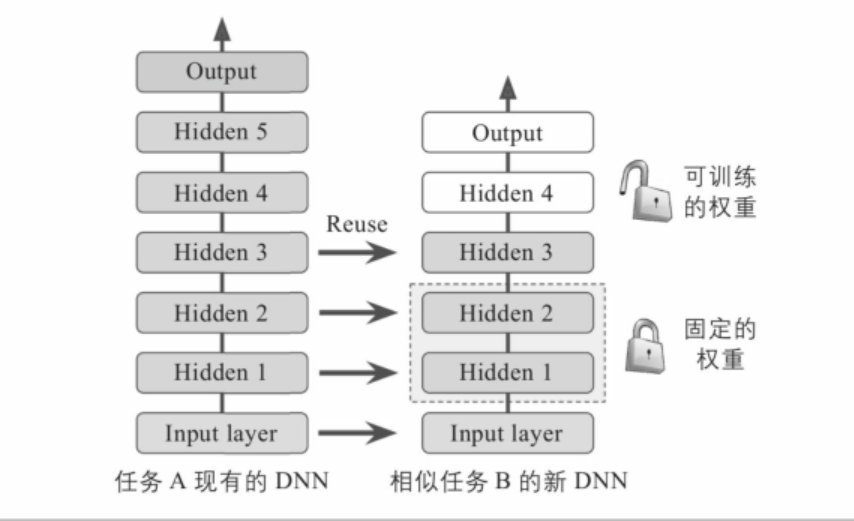

#### 用Keras进行迁移学习


案例：假设Fashion MNIST数据集仅包含8个类别，例
如，除凉鞋和衬衫之外的所有类别。有人在该数据集上建立并训练了
Keras模型，并获得了相当不错的性能（精度>90％）。我们将此模型称
为A。你现在要处理另一项任务：你有凉鞋和衬衫的图像，想要训练一
个二元分类器（正=衬衫，负=凉鞋）。你的数据集非常小，只有200张
带标签的图像。当你使用与模型A相同的架构训练一个新模型（称为模
型B）时，它的性能相当好（97.2％的精度）。

导入数据集：shion MNIST

X_train_A:除凉鞋和衬衫外的所有物品的所有图片(第5类和第6类)。  
X_train_B:一个小得多的训练集，只有前200张凉鞋或衬衫的图片。  

我们将在集合A(8类分类任务)上训练一个模型，并尝试重用它来处理集合B(二元分类)。 我们希望将一点知识从任务A转移到任务B，因为A组的课程(sneakers, ankle boots, coats, t恤等)与B组的课程(凉鞋和衬衫)有些相似。 然而，由于我们使用的是密集层，只有出现在相同位置的模式才能被重用(相比之下，卷积层传输得更好，因为学习的模式可以在图像的任何地方检测到，正如我们将在CNN章节中看到的)。  

In [125]:
def split_dataset(X, y):
    y_5_or_6 = (y == 5) | (y == 6) # sandals or shirts
    y_A = y[~y_5_or_6]
    y_A[y_A > 6] -= 2 # class indices 7, 8, 9 should be moved to 5, 6, 7
    y_B = (y[y_5_or_6] == 6).astype(np.float32) # binary classification task: is it a shirt (class 6)?
    return ((X[~y_5_or_6], y_A),
            (X[y_5_or_6], y_B))

(X_train_A, y_train_A), (X_train_B, y_train_B) = split_dataset(X_train, y_train)
(X_valid_A, y_valid_A), (X_valid_B, y_valid_B) = split_dataset(X_valid, y_valid)
(X_test_A, y_test_A), (X_test_B, y_test_B) = split_dataset(X_test, y_test)
X_train_B = X_train_B[:200]
y_train_B = y_train_B[:200]

In [126]:
X_train_A.shape

(43986, 28, 28)

In [127]:
X_train_B.shape

(200, 28, 28)

In [128]:
y_train_A[:30]

array([4, 0, 5, 7, 7, 7, 4, 4, 3, 4, 0, 1, 6, 3, 4, 3, 2, 6, 5, 3, 4, 5,
       1, 3, 4, 2, 0, 6, 7, 1], dtype=uint8)

In [129]:
y_train_B[:30]

array([1., 1., 0., 0., 0., 0., 1., 1., 1., 0., 0., 1., 1., 0., 0., 0., 0.,
       0., 0., 1., 1., 0., 0., 1., 1., 0., 1., 1., 1., 1.], dtype=float32)

In [130]:
tf.random.set_seed(42)
np.random.seed(42)

In [131]:
model_A = keras.models.Sequential()
model_A.add(keras.layers.Flatten(input_shape=[28, 28]))
for n_hidden in (300, 100, 50, 50, 50):
    model_A.add(keras.layers.Dense(n_hidden, activation="selu"))
model_A.add(keras.layers.Dense(8, activation="softmax"))

In [132]:
model_A.compile(loss="sparse_categorical_crossentropy",
                optimizer=keras.optimizers.SGD(lr=1e-3),
                metrics=["accuracy"])

In [133]:
history = model_A.fit(X_train_A, y_train_A, epochs=20,
                    validation_data=(X_valid_A, y_valid_A))

Train on 43986 samples, validate on 4014 samples
Epoch 1/20
43986/43986 [==============================] - 5s 108us/sample - loss: 0.5909 - accuracy: 0.8100 - val_loss: 0.3772 - val_accuracy: 0.8707
Epoch 2/20
43986/43986 [==============================] - 4s 93us/sample - loss: 0.3521 - accuracy: 0.8792 - val_loss: 0.3397 - val_accuracy: 0.8777
Epoch 3/20
43986/43986 [==============================] - 4s 97us/sample - loss: 0.3167 - accuracy: 0.8890 - val_loss: 0.3017 - val_accuracy: 0.8961
Epoch 4/20
43986/43986 [==============================] - 4s 102us/sample - loss: 0.2970 - accuracy: 0.8968 - val_loss: 0.2859 - val_accuracy: 0.9023
Epoch 5/20
43986/43986 [==============================] - 4s 100us/sample - loss: 0.2824 - accuracy: 0.9030 - val_loss: 0.2808 - val_accuracy: 0.9068
Epoch 6/20
43986/43986 [==============================] - 4s 94us/sample - loss: 0.2721 - accuracy: 0.9074 - val_loss: 0.2684 - val_accuracy: 0.9108
Epoch 7/20
43986/43986 [==============================

In [134]:
model_A.save("my_model_A.h5")

In [135]:
model_B = keras.models.Sequential()
model_B.add(keras.layers.Flatten(input_shape=[28, 28]))
for n_hidden in (300, 100, 50, 50, 50):
    model_B.add(keras.layers.Dense(n_hidden, activation="selu"))
model_B.add(keras.layers.Dense(1, activation="sigmoid"))

In [136]:
model_B.compile(loss="binary_crossentropy",
                optimizer=keras.optimizers.SGD(lr=1e-3),
                metrics=["accuracy"])

In [137]:
history = model_B.fit(X_train_B, y_train_B, epochs=20,
                      validation_data=(X_valid_B, y_valid_B))

Train on 200 samples, validate on 986 samples
Epoch 1/20
200/200 [==============================] - 1s 3ms/sample - loss: 0.9545 - accuracy: 0.4600 - val_loss: 0.6655 - val_accuracy: 0.5385
Epoch 2/20
200/200 [==============================] - 0s 436us/sample - loss: 0.5899 - accuracy: 0.6900 - val_loss: 0.4785 - val_accuracy: 0.8519
Epoch 3/20
200/200 [==============================] - 0s 442us/sample - loss: 0.4512 - accuracy: 0.8800 - val_loss: 0.4098 - val_accuracy: 0.8945
Epoch 4/20
200/200 [==============================] - 0s 440us/sample - loss: 0.3871 - accuracy: 0.9100 - val_loss: 0.3666 - val_accuracy: 0.9128
Epoch 5/20
200/200 [==============================] - 0s 424us/sample - loss: 0.3438 - accuracy: 0.9250 - val_loss: 0.3315 - val_accuracy: 0.9300
Epoch 6/20
200/200 [==============================] - 0s 434us/sample - loss: 0.3095 - accuracy: 0.9300 - val_loss: 0.3034 - val_accuracy: 0.9402
Epoch 7/20
200/200 [==============================] - 0s 419us/sample - loss: 0.

In [138]:
model.summary()

Model: "sequential_23"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_21 (Flatten)         (None, 784)               0         
_________________________________________________________________
batch_normalization_9 (Batch (None, 784)               3136      
_________________________________________________________________
dense_182 (Dense)            (None, 300)               235200    
_________________________________________________________________
batch_normalization_10 (Batc (None, 300)               1200      
_________________________________________________________________
activation_2 (Activation)    (None, 300)               0         
_________________________________________________________________
dense_183 (Dense)            (None, 100)               30000     
_________________________________________________________________
batch_normalization_11 (Batc (None, 100)             

首先，你需要加载模型A并基于该模型的层创建一个新模型。让我
们重用除输出层之外的所有层

In [140]:
#model_A = keras.models.load_model("my_model_A.h5")
model_B_on_A = keras.models.Sequential(model_A.layers[:-1])
model_B_on_A.add(keras.layers.Dense(1, activation="sigmoid"))

请注意，model_A和model_B_on_A现在共享一些层。当训练
model_B_on_A时，也会影响model_A。如果想避免这种情况，需要在重
用model_A的层之前对其进行克隆。为此，请使用clone_model（）来克
隆模型A的架构，然后复制其权重（因为clone_model（）不会克隆权
重）：

In [141]:
model_A_clone = keras.models.clone_model(model_A) 
model_A_clone.set_weights(model_A.get_weights()) 

现在你可以为任务B训练model_B_on_A，但是由于新的输出层是随
机初始化的，它会产生较大的错误（至少在前几个轮次内），因此将存
在较大的错误梯度，这可能会破坏重用的权重。为了避免这种情况，一
种方法是在前几个轮次时冻结重用的层，给新层一些时间来学习合理的
权重。为此，请将每一层的可训练属性设置为False并编译模型：

In [142]:
for layer in model_B_on_A.layers[:-1]: 
    layer.trainable = False 
 
model_B_on_A.compile(loss="binary_crossentropy", optimizer="sgd", 
                     metrics=["accuracy"])

现在，你可以训练模型几个轮次，然后解冻重用的层（这需要再次
编译模型），并继续进行训练来微调任务B的重用层。

In [143]:
history = model_B_on_A.fit(X_train_B, y_train_B, epochs=4, 
                           validation_data=(X_valid_B, y_valid_B)) 
 
for layer in model_B_on_A.layers[:-1]: 
    layer.trainable = True 
 
optimizer = keras.optimizers.SGD(lr=1e-4) # the default lr is 1e-2 
model_B_on_A.compile(loss="binary_crossentropy", optimizer=optimizer, 
                     metrics=["accuracy"]) 
history = model_B_on_A.fit(X_train_B, y_train_B, epochs=16, 
                           validation_data=(X_valid_B, y_valid_B)) 

Train on 200 samples, validate on 986 samples
Epoch 1/4
200/200 [==============================] - 1s 3ms/sample - loss: 0.1840 - accuracy: 0.9600 - val_loss: 0.1755 - val_accuracy: 0.9807
Epoch 2/4
200/200 [==============================] - 0s 377us/sample - loss: 0.1449 - accuracy: 0.9700 - val_loss: 0.1477 - val_accuracy: 0.9817
Epoch 3/4
200/200 [==============================] - 0s 366us/sample - loss: 0.1208 - accuracy: 0.9850 - val_loss: 0.1282 - val_accuracy: 0.9838
Epoch 4/4
200/200 [==============================] - 0s 380us/sample - loss: 0.1037 - accuracy: 0.9850 - val_loss: 0.1143 - val_accuracy: 0.9858
Train on 200 samples, validate on 986 samples
Epoch 1/16
200/200 [==============================] - 1s 3ms/sample - loss: 0.0950 - accuracy: 0.9850 - val_loss: 0.1134 - val_accuracy: 0.9858
Epoch 2/16
200/200 [==============================] - 0s 419us/sample - loss: 0.0941 - accuracy: 0.9850 - val_loss: 0.1126 - val_accuracy: 0.9858
Epoch 3/16
200/200 [====================

In [144]:
model_B.evaluate(X_test_B, y_test_B)

2000/1 [================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

[0.14446662163734436, 0.9695]

In [145]:
model_B_on_A.evaluate(X_test_B, y_test_B) 

2000/1 [================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

[0.09782943695783615, 0.9895]

最终结果：B_on_A模型的测试精度为98.95％，B的精度为96.95%，这意味着迁移学习将错误率从3.05％降低到了1.05％（2.9倍）

    为什么会好?尝试了许多配置，直到发现一个有明显改进的配置。如果你试着更改类别或随机种子，会发现改进通常会下降，甚至消失或反转。我所做的就是“折磨数据直到信服为止”。当论文看起来过于优秀时，你应该要怀疑：也许这个浮华的新技术实际上并没有多大帮助

事实证明，迁移学习在小型密集型网络中不能很
好地工作，大概是因为小型网络学习的模式很少，密集网络学习的是非
常特定的模式，这在其他任务中不是很有用。**迁移学习最适合使用深度
卷积神经网络**，该神经网络倾向于学习更为通用的特征检测器（尤其是
在较低层）。我们将在第14章中使用刚刚讨论的技术重新审视迁移学习

#### 无监督预训练

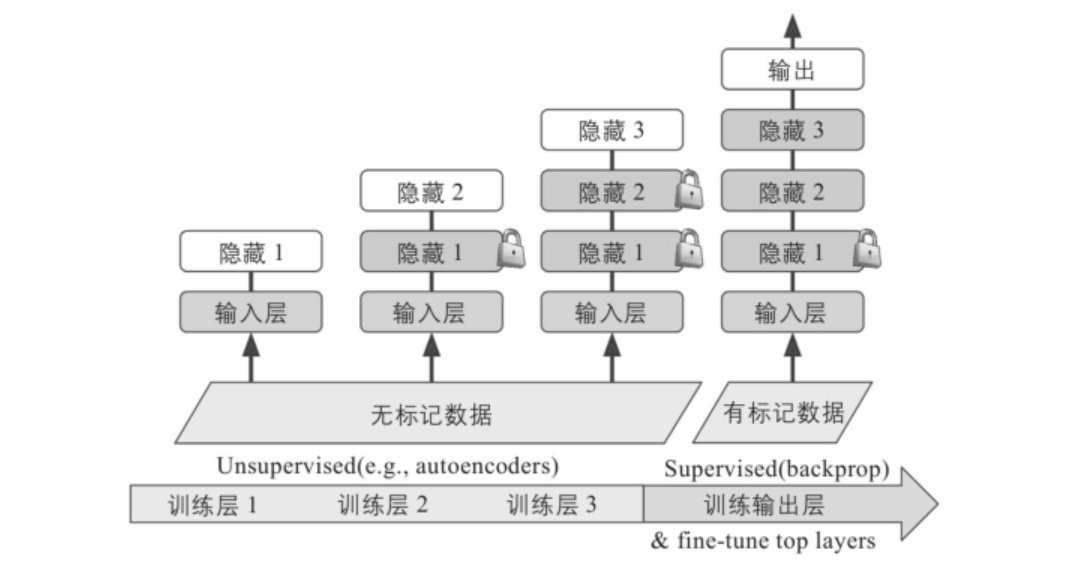

在无监督训练中，使用一个无监督学习技术对无标记数据（或
所有数据）进行训练，然后使用一个有监督学习技术对有标记数据进行
最后任务的微调，无监督部分可以一次训练一层，如图所示，也可以直
接训练整个模型。

#### 辅助任务的预训练

    如果你没有太多标记的训练数据，最后一个选择是在辅助任务上训练第一个神经网络，你可以轻松地为其获得或生成标记的训练数据，然后对实际任务重用该网络的较低层。第一个神经网络的较低层将学习特征检测器，第二个神经网络可能会重用这些特征检测器。

**2个应用**

①如果你要构建一个识别人脸的系统，每个人可能只有几张照
片，显然不足以训练一个好的分类器。收集每个人的数百张图片不切实
际。但是，你可以在网络上收集很多随机人物的图片，然后训练第一个
神经网络来检测两个不同的图片是否是同一个人。这样的网络将会学习
到很好的人脸特征检测器，因此重用其较低层可以使你用很少的训练数
据来训练一个好的人脸分类器。

②对于自然语言处理（NLP）应用，你可以下载数百万个文本文档的
语料库并从中自动生成带标签的数据。例如，你可以随机屏蔽一些单词
并训练模型来预测缺失的单词（例如，它应该能预测句子“What___you
saying”中的缺失单词可能是“are”或者“were”）。如果你可以训
练模型在此任务上达到良好的性能，那么它已经对语言有相当多的了
解，你当然可以在实际任务中重用它并在带标签的数据上进行微调（我
们将在第15章中讨论更多的预训练任务）

### 更快的优化器

本章结构：

_____________________

~~①梯度消失和梯度爆炸的含义及解决措施~~

~~②迁移学习和无监督预训练（解决标签数据很少的问题）~~

③极大加速训练大型模型的各种优化器

④针对大型神经网络的正则化技术

    介绍最受欢迎的算法：动量优化、Nesterov加速梯度、AdaGrad、RMSProp，最后是Adam和Nadam优化

#### 动量优化

基本想法：想象一下，一个保龄球在光滑的表面上沿着平缓的坡度滚动：它开
始时速度很慢，但很快会获得动量，直到最终达到终极速度（如果有摩
擦或空气阻力）。
——Boris Polyak在1964年提出的动量优化背后的非
常简单的想法

梯度下降通过直接减去权重的成本函数J（θ）的梯度
乘以学习率η（∆θJ（θ））来更新权重θ。等式是：θ←θ–
η∆θJ（θ）。它不关心较早的梯度是什么。如果局部梯度很小，则它会走得非常缓慢。

动量优化非常关心先前的梯度是什么：在每次迭代时，它都会从动
量向量m（乘以学习率η）中减去局部梯度，并通过添加该动量向量来
更新权重。换句话说，梯度是用于加速度而不是速度。
为了模拟某种摩擦机制并防止动量变得过大，该算法引入了一个新的超
参数β，称为动量，必须将其设置为0（高摩擦）和1（无摩擦）之间。
典型的动量值为0.9。

    在Keras中实现动量优化不费吹灰之力：只需要使用SGD优化器并设置其超参数momentum，然后就可躺下来看效果！

In [146]:
optimizer = keras.optimizers.SGD(lr=0.001, momentum=0.9)

#### Nesterov加速梯度

Yurii Nesterov于1983年提出的动量优化的一个小变体几乎总
是比原始动量优化要快。Nesterov加速梯度（Nesterov Accelerated
Gradient，NAG）方法也称为Nesterov动量优化，它不是在局部位置
θ，而是在θ+βm处沿动量方向稍微提前处测量成本函数的梯度

    NAG（Nesterov Accelerated Gradient）通常比常规动量优化更快。要使用它，只需在创建SGD优化器时设置nesterov=True即可

In [147]:
optimizer = keras.optimizers.SGD(lr=0.001, momentum=0.9, nesterov=True)

#### AdaGrad

    AdaGrad算法通过沿最陡峭的维度按比例缩小梯度向量

可以较早地修正其方向，使之指向最优解

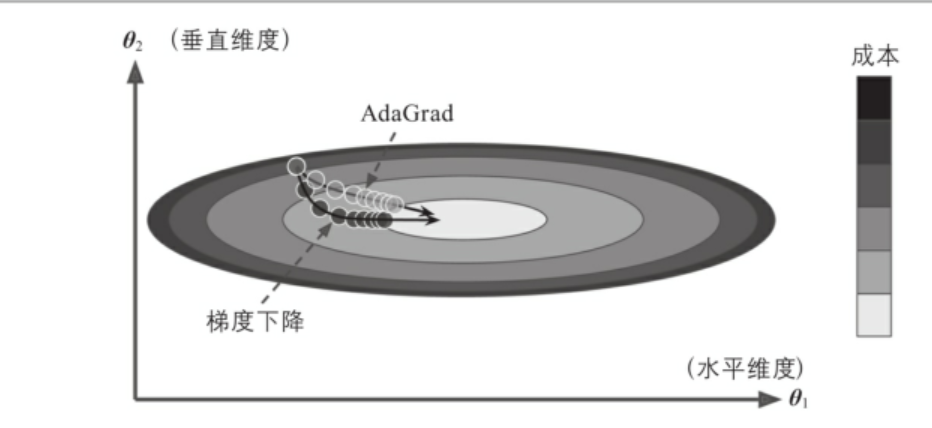

In [148]:
optimizer = keras.optimizers.Adagrad(lr=0.001)

#### RMSProp

    AdaGrad有下降太快，永远不会收敛到全局最优解的风险。RMSProp算法通过只是累加最近迭代中的梯度（而不是自训练开始以来的所有梯度）来解决这个问题。它通过在第一步中使用指数衰减来实现

In [149]:
optimizer = keras.optimizers.RMSprop(lr=0.001, rho=0.9) 

除了非常简单的问题外，该优化器几乎总是比AdaGrad表现更好。实际上，直到Adam优化出现之前，它一直是许多研究人员首选的优化算法。

#### Adam和Nadam优化

    Adam代表自适应矩估计，结合了动量优化和RMSProp的思想：就像动量优化一样，它跟踪过去梯度的指数衰减平均值。就像RMSProp一样，它跟踪过去平方梯度的指数衰减平均值

In [150]:
optimizer = keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999)

    Nadam优化是Adam优化加上Nesterov技巧，因此其收敛速度通常比Adam稍快。在他介绍这种技术的报告中，研究人员Timothy Dozat在各种任务上对许多不同的优化器进行了比较，发现Nadam总体上胜过Adam，但有时不如RMSProp。

In [151]:
optimizer = keras.optimizers.Nadam(lr=0.001, beta_1=0.9, beta_2=0.999)

Tips~到目前为止讨论的所有优化技术都仅仅依赖于一阶偏导数，很难应用于深度神经网络，因为每个输出有n2个Hessian，由于DNN通常具有成千上万的参数，因此二阶优化算法甚至不适合存储在内存中

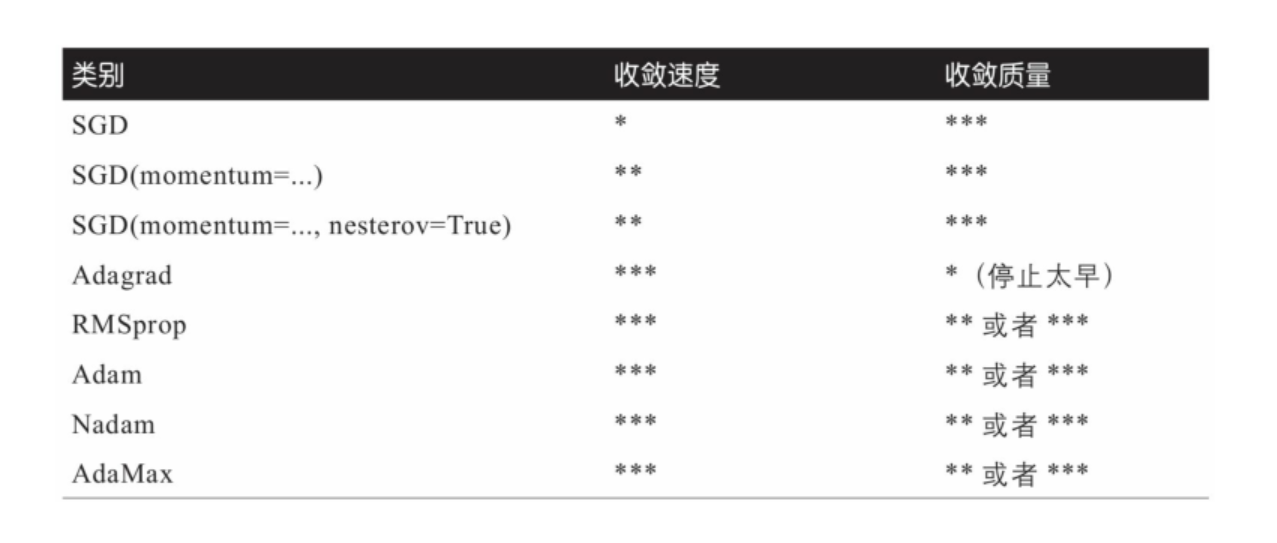

#### 学习率调度

    如果你的计算力预算有限，则可能必须先中断训练，然后才能正确收敛，从而产生次优解决

如果你从一个较大的学习率开始，一旦训练没有取得进展后就降低它，那与恒定学习率相比，你就可以更快地找到一个最优解。有许多不同的策略可以降低训练期间的学习率。

    以下这些是最常用的学习率调度

①幂调度

将学习率设置为迭代次数t的函数：η（t）=η0/（1+t/s）c。初
始学习率η0、幂c（通常设置为1）和步骤s是超参数。学习率在每一步
都会下降。在s个步骤之后，它下降到η0/2。再在s个步骤之后，它下
降到η0/3，然后下降到η0/4，然后是η0/5，以此类推。如你所见，
此调度开始迅速下降，然后越来越慢。当然，幂调度需要调整η0和
s（可能还有c）。

②指数调度

将学习速率设置为η（t）=η0 0.1t/s。学习率每s步将逐渐下降
10倍。幂调度越来越缓慢地降低学习率，而指数调度则使学习率每s步
降低10倍。

③分段恒定调度

对一些轮次使用恒定的学习率（例如，对于5个轮次，η0=0.1），
对于另外一些轮次使用较小的学习率（例如，对于50个轮次，
η0=0.001），以此类推。尽管这个方法可以很好地工作，但仍需要仔
细研究以找出正确的学习率顺序以及使用它们的轮次。

    在Keras中实现幂调度是最简单的选择：只需在创建优化器时设置超参数decay即可

In [ ]:
optimizer = keras.optimizers.SGD(lr=0.01, decay=1e-4)

decay是s（学习率除以多个数字单位所需要的步数）的倒数，Keras假定c等于1。

In [76]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(100, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(10, activation="softmax")
])
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])


In [77]:
n_epochs = 25
history = model.fit(X_train_scaled, y_train, epochs=n_epochs,
                    validation_data=(X_valid_scaled, y_valid))

Train on 55000 samples, validate on 5000 samples
Epoch 1/25
55000/55000 [==============================] - 4s 75us/sample - loss: 1.3534 - accuracy: 0.5228 - val_loss: 0.9119 - val_accuracy: 0.6848
Epoch 2/25
55000/55000 [==============================] - 4s 69us/sample - loss: 0.8259 - accuracy: 0.7133 - val_loss: 0.7494 - val_accuracy: 0.7374
Epoch 3/25
55000/55000 [==============================] - 4s 70us/sample - loss: 0.7178 - accuracy: 0.7506 - val_loss: 0.6773 - val_accuracy: 0.7598
Epoch 4/25
55000/55000 [==============================] - 4s 71us/sample - loss: 0.6608 - accuracy: 0.7708 - val_loss: 0.6345 - val_accuracy: 0.7770
Epoch 5/25
55000/55000 [==============================] - 4s 72us/sample - loss: 0.6236 - accuracy: 0.7837 - val_loss: 0.6041 - val_accuracy: 0.7876
Epoch 6/25
55000/55000 [==============================] - 4s 73us/sample - loss: 0.5968 - accuracy: 0.7931 - val_loss: 0.5820 - val_accuracy: 0.7962
Epoch 7/25
55000/55000 [==============================] -

In [78]:
learning_rate = 0.01
decay = 1e-4
batch_size = 32
n_steps_per_epoch = len(X_train) // batch_size
epochs = np.arange(n_epochs)
lrs = learning_rate / (1 + decay * epochs * n_steps_per_epoch)

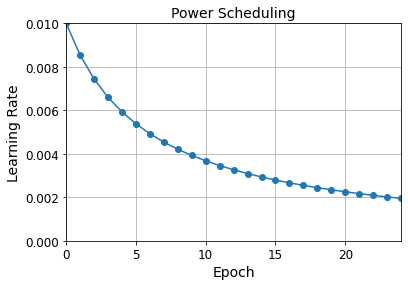

In [79]:
plt.plot(epochs, lrs,  "o-")
plt.axis([0, n_epochs - 1, 0, 0.01])
plt.xlabel("Epoch")
plt.ylabel("Learning Rate")
plt.title("Power Scheduling", fontsize=14)
plt.grid(True)
plt.show()

### 通过正则化避免过拟合

拥有数千个参数，你可以拟合出整个动物园。深度神经网络通常具
有数万个参数，有时甚至有数百万个。这给它们带来了难以置信的自由
度，意味着它们可以拟合各种各样的复杂数据集。但是，这种巨大的灵
活性也使网络易于过拟合训练集。

本章结构：
_______________________

~~①梯度消失和梯度爆炸的含义及解决措施~~

~~②迁移学习和无监督预训练（解决标签数据很少的问题）~~

~~③极大加速训练大型模型的各种优化器~~

④针对大型神经网络的正则化技术

####  ℓ1 和 ℓ2 的正则化

    拟合过程中通常都倾向于让权值尽可能小，最后构造一个所有参数都比较小的模型。因为一般认为参数值小的模型比较简单，能适应不同的数据集，也在一定程度上避免了过拟合现象。

就像在第4章中对简单线性模型所做的一样，可以使用ℓ2正则化来
约束神经网络的连接权重，如果想要稀疏模型（许多权重等于0）则可
以使用ℓ1正则化。以下是使用0.01的正则化因子将ℓ2正则化应用于
Keras层的连接权重的方法：

In [7]:
layer = keras.layers.Dense(100, activation="elu",
                           kernel_initializer="he_normal",
                           kernel_regularizer=keras.regularizers.l2(0.01))
# or l1(0.1) for ℓ1 regularization with a factor or 0.1
# or l1_l2(0.1, 0.01) for both ℓ1 and ℓ2 regularization, with factors 0.1 and 0.01 respectively

In [73]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, activation="elu",
                       kernel_initializer="he_normal",
                       kernel_regularizer=keras.regularizers.l2(0.01)),
    keras.layers.Dense(100, activation="elu",
                       kernel_initializer="he_normal",
                       kernel_regularizer=keras.regularizers.l2(0.01)),
    keras.layers.Dense(10, activation="softmax",
                       kernel_regularizer=keras.regularizers.l2(0.01))
])
model.compile(loss="sparse_categorical_crossentropy", optimizer="nadam", metrics=["accuracy"])
n_epochs = 2
history = model.fit(X_train_scaled, y_train, epochs=n_epochs,
                    validation_data=(X_valid_scaled, y_valid))

Train on 55000 samples, validate on 5000 samples
Epoch 1/2
55000/55000 [==============================] - 8s 145us/sample - loss: 1.6417 - accuracy: 0.8107 - val_loss: 0.7628 - val_accuracy: 0.8068
Epoch 2/2
55000/55000 [==============================] - 7s 131us/sample - loss: 0.7190 - accuracy: 0.8262 - val_loss: 0.7174 - val_accuracy: 0.8224


这使代码很难看且容易出错。为了避免这种情况，你可以尝试使用循环来重构代码。另一种选择是使用Python的functools.partial（）函数

In [74]:
from functools import partial

RegularizedDense = partial(keras.layers.Dense,
                           activation="elu",
                           kernel_initializer="he_normal",
                           kernel_regularizer=keras.regularizers.l2(0.01))

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    RegularizedDense(300),
    RegularizedDense(100),
    RegularizedDense(10, activation="softmax")
])
model.compile(loss="sparse_categorical_crossentropy", optimizer="nadam", metrics=["accuracy"])
n_epochs = 2
history = model.fit(X_train_scaled, y_train, epochs=n_epochs,
                    validation_data=(X_valid_scaled, y_valid))

Train on 55000 samples, validate on 5000 samples
Epoch 1/2
55000/55000 [==============================] - 8s 146us/sample - loss: 1.6584 - accuracy: 0.8127 - val_loss: 0.7619 - val_accuracy: 0.8052
Epoch 2/2
55000/55000 [==============================] - 7s 131us/sample - loss: 0.7191 - accuracy: 0.8273 - val_loss: 0.7139 - val_accuracy: 0.8262


l2（）函数返回一个正则化函数，在训练过程中的每个步骤都将调
用该正则化函数来计算正则化损失。然后将其添加到最终损失中。如你
所料，如果需要l1正则化，可以只使用keras.regularizers.l1（）。

如果你同时需要l1和l2正则化，请使用keras.regularizers.l1_l2（）
（同时指定两个正则化因子）。

#### dropout

    对于深度神经网络，dropout是最受欢迎的正则化技术之一。

只需要增加dropout，即使最先进的神经网络也能获得1～
2%的准确率提升。这听起来可能不算很多，但是当模型已经具有95％的
准确率时，将准确率提高2％意味着将错误率降低了近40％（从5％的错
误率降低到大约3％）。

这是一个非常简单的算法：在每个训练步骤中，每个神经元（包括
输入神经元，但始终不包括输出神经元）都有暂时“删除”的概率p，
这意味着在这个训练步骤中它被完全忽略，但在下一步中可能处于活动
状态。超参数p称为dropout率，通常设置为10％到50％：
在循环神经网络中接近20～30％（见第15章），在卷积神经网络中接近
40～50％（见第14章）。训练后，神经元不再被删除。

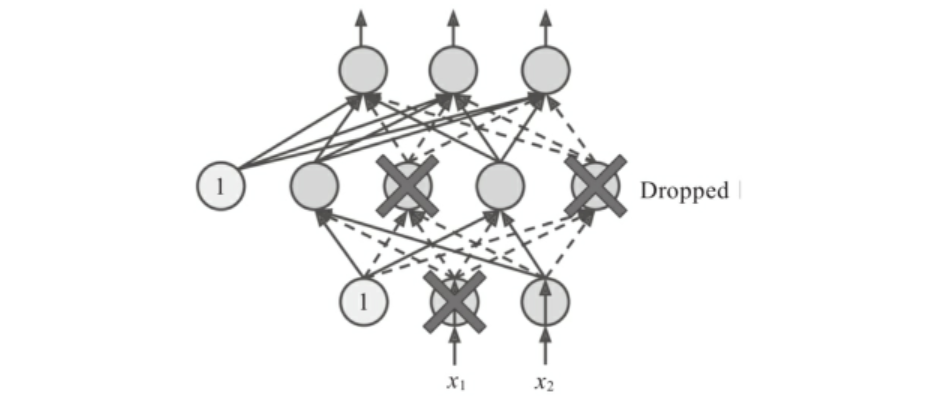

使用dropout正则化，在每个训练迭代中，一个或多个层中的
所有神经元的随机子集（输出层除外）被“删除”：这些神经元在这个
迭代中输出0（用虚线箭头表示）

    这种破坏性技术完全有效。如果公司告诉员工每天早上扔硬币来决定是否去上班，公司的业绩会更好吗？好吧，谁知道呢？也许会！

要使用Keras实现dropout，可以使用keras.layers.Dropout层。在
训练期间，它会随机丢弃一些输入（将它们设置为0），然后将其余输
入除以保留概率。训练之后，它什么都不做，只是将输入传递到下一
层。以下代码使用0.2的dropout率在每个Dense层之前应用dropout正则
化：

In [75]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dropout(rate=0.2),
    keras.layers.Dense(300, activation="elu", kernel_initializer="he_normal"),
    keras.layers.Dropout(rate=0.2),
    keras.layers.Dense(100, activation="elu", kernel_initializer="he_normal"),
    keras.layers.Dropout(rate=0.2),
    keras.layers.Dense(10, activation="softmax")
])
model.compile(loss="sparse_categorical_crossentropy", optimizer="nadam", metrics=["accuracy"])
n_epochs = 2
history = model.fit(X_train_scaled, y_train, epochs=n_epochs,
                    validation_data=(X_valid_scaled, y_valid))

Train on 55000 samples, validate on 5000 samples
Epoch 1/2
55000/55000 [==============================] - 8s 151us/sample - loss: 0.5668 - accuracy: 0.8040 - val_loss: 0.3583 - val_accuracy: 0.8690
Epoch 2/2
55000/55000 [==============================] - 8s 141us/sample - loss: 0.4211 - accuracy: 0.8448 - val_loss: 0.3723 - val_accuracy: 0.8616


    如果要基于SELU激活函数（如前所述）对自归一化网络进行正则化，则应使用alpha dropout：这是dropout的一种变体，它保留了其输入的均值和标准差（在与SELU相同的论文中介绍，因为常规的dropout会破坏自归一化）。

#### 蒙特卡罗（MC）Dropout

    仅对测试集进行100个预测，设置training=True来确保Dropout层处于激活状态，然后把预测堆叠起来。由于dropout处于激活状态，因此所有预测都将有所不同。回想一下，predict（）返回一个矩阵，其中每个实例一行，每个类一列。因为测试集中有10 000个实例和10个类，所以这是一个形状为[10000，10]的矩阵。我们堆叠了100个这样的矩阵，因此y_probas是一个形状为[100，10000，10]的数组。一旦我们对第一个维度进行平均（axis=0），我们得到y_proba，它是形状[10000，10]的数组，就像我们通过单个预测得到的一样。对具有dropout功能的多个预测进行平均，这使蒙特卡罗估计通常比关闭dropout的单个预测的结果更可靠。

In [182]:
tf.random.set_seed(42)
np.random.seed(42)

In [183]:
#导入数据集：shion MNIST
(X_train_full, y_train_full), (X_test, y_test) = keras.datasets.fashion_mnist.load_data()
X_train_full = X_train_full / 255.0
X_test = X_test / 255.0
X_valid, X_train = X_train_full[:5000], X_train_full[5000:]
y_valid, y_train = y_train_full[:5000], y_train_full[5000:]

Fashion MNIST测试集中第一个实例的预测

In [184]:
y_probas = np.stack([model(X_test_scaled, training=True)
                     for sample in range(100)])
y_proba = y_probas.mean(axis=0)
y_std = y_probas.std(axis=0)

In [185]:
pixel_means = X_train.mean(axis=0, keepdims=True)
pixel_stds = X_train.std(axis=0, keepdims=True)
X_train_scaled = (X_train - pixel_means) / pixel_stds
X_valid_scaled = (X_valid - pixel_means) / pixel_stds
X_test_scaled = (X_test - pixel_means) / pixel_stds

看起来每一类都有可能，不是个好模型...

In [186]:
np.round(model.predict(X_test_scaled[:1]), 2)

array([[0.02, 0.03, 0.19, 0.02, 0.08, 0.19, 0.27, 0.02, 0.11, 0.07]],
      dtype=float32)

将其与dropout激活时所做的预测进行比较：

In [187]:
np.round(y_probas[:, :1], 2)

array([[[0.02, 0.03, 0.19, 0.02, 0.08, 0.19, 0.27, 0.02, 0.11, 0.07]],

       [[0.02, 0.03, 0.19, 0.02, 0.08, 0.19, 0.27, 0.02, 0.11, 0.07]],

       [[0.02, 0.03, 0.19, 0.02, 0.08, 0.19, 0.27, 0.02, 0.11, 0.07]],

       [[0.02, 0.03, 0.19, 0.02, 0.08, 0.19, 0.27, 0.02, 0.11, 0.07]],

       [[0.02, 0.03, 0.19, 0.02, 0.08, 0.19, 0.27, 0.02, 0.11, 0.07]],

       [[0.02, 0.03, 0.19, 0.02, 0.08, 0.19, 0.27, 0.02, 0.11, 0.07]],

       [[0.02, 0.03, 0.19, 0.02, 0.08, 0.19, 0.27, 0.02, 0.11, 0.07]],

       [[0.02, 0.03, 0.19, 0.02, 0.08, 0.19, 0.27, 0.02, 0.11, 0.07]],

       [[0.02, 0.03, 0.19, 0.02, 0.08, 0.19, 0.27, 0.02, 0.11, 0.07]],

       [[0.02, 0.03, 0.19, 0.02, 0.08, 0.19, 0.27, 0.02, 0.11, 0.07]],

       [[0.02, 0.03, 0.19, 0.02, 0.08, 0.19, 0.27, 0.02, 0.11, 0.07]],

       [[0.02, 0.03, 0.19, 0.02, 0.08, 0.19, 0.27, 0.02, 0.11, 0.07]],

       [[0.02, 0.03, 0.19, 0.02, 0.08, 0.19, 0.27, 0.02, 0.11, 0.07]],

       [[0.02, 0.03, 0.19, 0.02, 0.08, 0.19, 0.27, 0.02, 0.11, 0

一旦我们对第一个维度进行平均，我们将获得以下MC Dropout预测：。

In [188]:
np.round(y_proba[:1], 2)

array([[0.02, 0.03, 0.19, 0.02, 0.08, 0.19, 0.27, 0.02, 0.11, 0.07]],
      dtype=float32)

概率估计的标准差：

In [189]:
y_std = y_probas.std(axis=0)
np.round(y_std[:1], 2)

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]], dtype=float32)

In [190]:
y_pred = np.argmax(y_proba, axis=1)

概率估计值存在很大差异：如果你要建立风险敏感的系统
（例如医疗或金融系统），应该格外小心地对待这种不确定的预测。此外，模型的准确率如下：

In [191]:
accuracy = np.sum(y_pred == y_test) / len(y_test)
accuracy

0.1539

如果你的模型包含在训练过程中以特殊方式运行的其他层（例如BatchNormalization层），则你不应像我们刚才那样强制训练模式。相反，你应该使用以下MCDropout类来替换Dropout层

In [99]:
class MCDropout(keras.layers.Dropout):
    def call(self, inputs):
        return super().call(inputs, training=True)

class MCAlphaDropout(keras.layers.AlphaDropout):
    def call(self, inputs):
        return super().call(inputs, training=True)

In [100]:
tf.random.set_seed(42)
np.random.seed(42)

In [101]:
mc_model = keras.models.Sequential([
    MCAlphaDropout(layer.rate) if isinstance(layer, keras.layers.AlphaDropout) else layer
    for layer in model.layers
])

In [102]:
mc_model.summary()

Model: "sequential_18"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_16 (Flatten)         (None, 784)               0         
_________________________________________________________________
dense_65 (Dense)             (None, 300)               235500    
_________________________________________________________________
dense_66 (Dense)             (None, 100)               30100     
_________________________________________________________________
dense_67 (Dense)             (None, 10)                1010      
Total params: 266,610
Trainable params: 266,610
Non-trainable params: 0
_________________________________________________________________


In [103]:
optimizer = keras.optimizers.SGD(lr=0.01, momentum=0.9, nesterov=True)
mc_model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])

In [104]:
mc_model.set_weights(model.get_weights())

In [105]:
np.round(np.mean([mc_model.predict(X_test_scaled[:1]) for sample in range(100)], axis=0), 2)

array([[0.  , 0.  , 0.  , 0.  , 0.  , 0.16, 0.  , 0.39, 0.01, 0.44]],
      dtype=float32)

    MC Dropout是一种出色的技术，可以提升dropout模型并提供更好的不确定性估计。当然，由于这只是训练期间的常规dropout，所以它也像正则化函数

#### 最大范数正则化

对于神经网络而言，另一种流行的正则化技术称为最大范数正则
化：对于每个神经元，它会限制传入连接的权重w，使得||w||2≤r，其
中r是最大范数超参数，||w||2是范数。

最大范数正则化不会把正则化损失项添加到总体损失函数中。取而
代之的是，通常在每个训练步骤后通过计算||w||2来实现，如有需要，
请重新缩放 。

减小r会增加正则化的数量，并有助于减少过拟合。最大范数正则
化还可以帮助缓解不稳定的梯度问题（如果你未使用“批量归一
化”）。

要在Keras中实现最大范数正则化，请将每个隐藏层的
kernel_constraint参数设置为具有适当最大值的max_norm（）约束，
如下所示：

In [106]:
layer = keras.layers.Dense(100, activation="selu", kernel_initializer="lecun_normal",
                           kernel_constraint=keras.constraints.max_norm(1.))

In [107]:
MaxNormDense = partial(keras.layers.Dense,
                       activation="selu", kernel_initializer="lecun_normal",
                       kernel_constraint=keras.constraints.max_norm(1.))

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    MaxNormDense(300),
    MaxNormDense(100),
    keras.layers.Dense(10, activation="softmax")
])
model.compile(loss="sparse_categorical_crossentropy", optimizer="nadam", metrics=["accuracy"])
n_epochs = 2
history = model.fit(X_train_scaled, y_train, epochs=n_epochs,
                    validation_data=(X_valid_scaled, y_valid))

Train on 55000 samples, validate on 5000 samples
Epoch 1/2
55000/55000 [==============================] - 8s 151us/sample - loss: 0.4756 - accuracy: 0.8330 - val_loss: 0.3671 - val_accuracy: 0.8692
Epoch 2/2
55000/55000 [==============================] - 8s 141us/sample - loss: 0.3567 - accuracy: 0.8696 - val_loss: 0.3573 - val_accuracy: 0.8714


每次训练迭代后，模型的fit（）方法会调用由max_norm（）返回
的对象，将层的权重传递给该对象，并获得返回的缩放权重，然后替换
该层的权重。如第12章所述，如果需要，你可以定义自己的自定义约束
函数，并将其用作kernel_constraint。你还可以通过设置
bias_constraint参数来约束偏置项。
max_norm（）函数的参数axis默认为0。Dense层通常具有形状为
[输入数量，神经元数量]的权重，因此使用axis=0意味着最大范数约束
将独立应用于每个神经元的权重向量。如果你要将最大范数与卷积层一
起使用（见第14章），请确保正确设置max_norm（）约束的axis参数
（通常axis=[0，1，2]）。

——————————                这里是底线                                         ——————————————